In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def generate_synthetic_data(n=5000):
    np.random.seed(42)
    random.seed(42)
    customer_ids = [f"CUST{i}" for i in range(1, n + 1)]
    age = np.random.randint(18, 80, n)
    gender = np.random.choice(['Male', 'Female'], n)
    contract_type = np.random.choice(['Month-to-month', 'One year', 'Two year'], n, p=[0.5, 0.3, 0.2])
    monthly_charges = np.round(np.random.uniform(20, 120, n), 2)
    tenure = np.random.randint(1, 72, n)
    total_charges = np.round(monthly_charges * tenure + np.random.uniform(-10, 10, n), 2)
    tech_support = np.random.choice(['Yes', 'No'], n, p=[0.3, 0.7])
    internet_service = np.random.choice(['DSL', 'Fiber optic', 'No'], n, p=[0.4, 0.4, 0.2])
    paperless_billing = np.random.choice(['Yes', 'No'], n, p=[0.7, 0.3])
    payment_method = np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n)
    churn = np.random.choice(['Yes', 'No'], n, p=[0.2, 0.8])
    df = pd.DataFrame({
        'CustomerID': customer_ids,
        'Age': age,
        'Gender': gender,
        'ContractType': contract_type,
        'MonthlyCharges': monthly_charges,
        'TotalCharges': total_charges,
        'TechSupport': tech_support,
        'InternetService': internet_service,
        'Tenure': tenure,
        'PaperlessBilling': paperless_billing,
        'PaymentMethod': payment_method,
        'Churn': churn
    })
    df['AverageMonthlyCharges'] = df['TotalCharges'] / df['Tenure']
    df['CustomerLifetimeValue'] = df['Tenure'] * df['MonthlyCharges']
    return df
data = generate_synthetic_data()
print(data.head())

  CustomerID  Age  Gender    ContractType  MonthlyCharges  TotalCharges  \
0      CUST1   56    Male        Two year           85.58       1541.69   
1      CUST2   69  Female  Month-to-month           69.70       4731.09   
2      CUST3   46  Female  Month-to-month           23.21       1111.04   
3      CUST4   32  Female        One year           81.23       5680.62   
4      CUST5   60  Female        One year           91.62       6142.92   

  TechSupport InternetService  Tenure PaperlessBilling     PaymentMethod  \
0          No              No      18              Yes       Credit card   
1          No     Fiber optic      68              Yes  Electronic check   
2         Yes             DSL      48              Yes      Mailed check   
3         Yes     Fiber optic      70              Yes       Credit card   
4          No              No      67               No     Bank transfer   

  Churn  AverageMonthlyCharges  CustomerLifetimeValue  
0    No              85.649444      

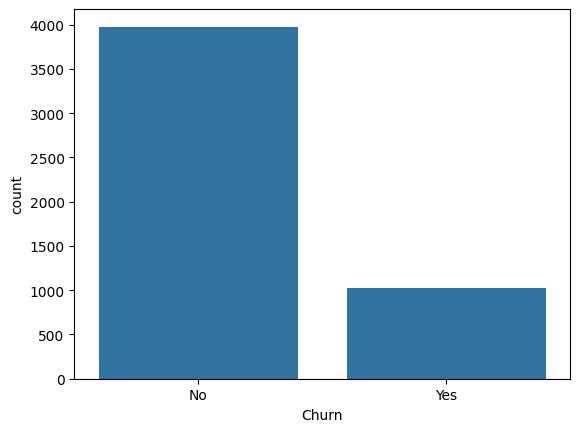

In [3]:
sns.countplot(x='Churn', data=data)
plt.show()

In [4]:
data.fillna(data.select_dtypes(include=[np.number]).mean(), inplace=True)
label_encoders = {}
for col in ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
X = data.drop(columns=['CustomerID', 'Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
feature_extractor = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization()
])
feature_extractor.compile(optimizer='adam', loss='mse')
X_train_dl = feature_extractor.predict(X_train, batch_size=32)
X_test_dl = feature_extractor.predict(X_test, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [6]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train_dl, y_train)
y_pred = rf_model.predict(X_test_dl)
y_pred_proba = rf_model.predict_proba(X_test_dl)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Enhanced Random Forest Accuracy: {accuracy:.4f}")
print(f"Enhanced ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Enhanced Random Forest Accuracy: 0.6330
Enhanced ROC AUC Score: 0.5095

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       807
           1       0.20      0.31      0.24       193

    accuracy                           0.63      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.69      0.63      0.66      1000


Confusion Matrix:
 [[574 233]
 [134  59]]


In [7]:
joblib.dump(rf_model, "dl_random_forest_model.pkl")
feature_extractor.save("feature_extractor.h5")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [10]:
rf_model = joblib.load("dl_random_forest_model.pkl")
from tensorflow.keras.losses import mse
feature_extractor = keras.models.load_model("feature_extractor.h5", custom_objects={'mse': mse})
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")
new_customer = pd.DataFrame({
    'Age': [30],
    'Gender': ['Male'],
    'ContractType': ['Month-to-month'],
    'MonthlyCharges': [70.5],
    'TotalCharges': [850],
    'TechSupport': ['No'],
    'InternetService': ['Fiber optic'],
    'Tenure': [12],
    'PaperlessBilling': ['Yes'],
    'PaymentMethod': ['Electronic check'],
    'AverageMonthlyCharges': [70.5],
    'CustomerLifetimeValue': [70.5 * 12]
})
for col in ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']:
    new_customer[col] = label_encoders[col].transform(new_customer[col])
new_customer_scaled = scaler.transform(new_customer)
new_customer_dl = feature_extractor.predict(new_customer_scaled)
churn_prediction = rf_model.predict(new_customer_dl)
churn_probability = rf_model.predict_proba(new_customer_dl)[:, 1]
print(f"Churn Prediction: {'Yes' if churn_prediction[0] == 1 else 'No'}")
print(f"Churn Probability: {churn_probability[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Churn Prediction: No
Churn Probability: 0.36
